##### Please include TIS-Ecoli.txt in the same folder to run the code

**Importing libraries**

In [21]:
import numpy as np
import matplotlib.pyplot as plt

**read Ecoli file**

In [2]:
f = open("TIS-Ecoli.txt", "r")

**transform this file into a matrix using numpy**

In [3]:
Ecoli_mat = np.loadtxt('TIS-Ecoli.txt', dtype=str)


**Next step is to identify how many true start codons are in the sequences and how many false ones**
**For this we use For loops**

In [4]:
# Declaring our variables
true_start_count = 0
false_start_left_count = 0
false_start_right_count = 0

In [5]:
for sequence in Ecoli_mat:
    # Check true start codon at position 101 (index 100 due to zero-indexing)
    if sequence[100:103] in ['ATG', 'GTG', 'TTG']:
        true_start_count += 1
    
    # Check non-coding region (left of 101)
    for i in range(0, 100):
        if sequence[i:i+3] in ['ATG', 'GTG', 'TTG']:
            false_start_left_count += 1

    # Check coding region (right of 101)
    for i in range(102, len(sequence)-2):
        if sequence[i:i+3] in ['ATG', 'GTG', 'TTG']:
            false_start_right_count += 1

In [6]:
print("True start codons at position 101:", true_start_count)
print("False start codons in non-coding region:", false_start_left_count)
print("False start codons in coding region:", false_start_right_count)

True start codons at position 101: 721
False start codons in non-coding region: 3227
False start codons in coding region: 3083


#### Questions:
##### Do all sequences show a valid true start codon? Do you see a difference in the distribution of codon variants between true and false ones?

In [7]:
print (len(Ecoli_mat))

722


In [8]:
# 722 is 1 more sequence than the 721 number that we got for true start codons
# We will try and identify this sequence by using enumerate
# enumerate adds a counter at the start of each line, this way we can find which indexed line is faulty
for i, sequence in enumerate(Ecoli_mat):
    if sequence[100:103] not in ['ATG', 'GTG', 'TTG']:
        print(f"Sequence {i} does not have a valid start codon at position 101.")

Sequence 303 does not have a valid start codon at position 101.


##### To answer the first question 1 sequence did not show a valid start codon which is sequence 303.

##### Q2: Yes, there is a difference in the distribution of start codon variants between true and false positions. While 721 sequences show a true start codon at position 101, false start codons appear frequently in both non-coding (3,227) and coding (3,083) regions. This suggests that the codon sequence alone is not a reliable indicator of start position, as similar sequences appear widely across both coding and non-coding regions.

In [9]:
# Initializing parameters and matrices
n_positions = 30  # PWM length
n_bases = 4  # A, T, G, C
background_probabilities = np.full((n_bases,), 0.25)  # Uniform background model for each nucleotide

# Initializing PWM matrix (4 rows for bases, 30 columns for positions before the start codon)
pwm_mat = np.zeros((n_bases, n_positions))


In [10]:
#Converting each sequence to a binary matrix indicating nucleotide positions
binary_matrices = []

for i_seq, sequence in enumerate(Ecoli_mat):
    # Extract the 30-base region before the start codon
    sequence_part = list(sequence[70:100])  # Positions 71 to 100 in zero-indexed terms, converted to list for element-wise comparision

    # Create a 4x30 Boolean matrix for each base
    binary_mat = np.array([
        np.array(sequence_part) == 'A',  # Row for 'A'
        np.array(sequence_part) == 'T',  # Row for 'T'
        np.array(sequence_part) == 'G',  # Row for 'G'
        np.array(sequence_part) == 'C'   # Row for 'C'
    ])
    
    
    # Append this binary matrix to the list for later processing
    binary_matrices.append(binary_mat)

# Print to verify the shape and first binary matrix
print("Binary matrix for the first sequence (4x30):")
print(binary_matrices[0])


Binary matrix for the first sequence (4x30):
[[False  True  True False False False False  True False False False False
  False  True False False  True  True False  True False  True False False
   True  True False  True False False]
 [False False False False  True False False False False  True  True  True
  False False False  True False False  True False False False False False
  False False  True False False  True]
 [ True False False False False  True  True False  True False False False
   True False False False False False False False False False  True  True
  False False False False False False]
 [False False False  True False False False False False False False False
  False False  True False False False False False  True False False False
  False False False False  True False]]


##### Next step is to count base frequencies at each position

In [11]:
# Converting the list of binary matrices to a 3D numpy array for easier summing
binary_matrices_arr = np.array(binary_matrices)  # Shape: (num_sequences, 4, 30)

# Sum along the first axis (axis=0) to get base counts at each position
base_counts_mat = np.sum(binary_matrices_arr, axis=0)

print("Base counts matrix (4x30):")
print(base_counts_mat)


Base counts matrix (4x30):
[[203 196 207 182 209 197 215 218 230 222 243 237 255 262 251 241 251 279
  262 249 236 229 294 260 265 256 266 320 199 197]
 [220 184 196 205 196 205 196 196 202 222 186 205 211 197 199 198 165 149
  124  74  69  73  90 140 186 195 189 109 233 197]
 [136 164 131 161 126 161 139 136 125 126 147 116 110 117 121 152 185 177
  242 333 377 390 281 244 175 146 121 161  83 108]
 [163 178 188 174 191 159 172 172 165 152 146 164 146 146 151 131 121 117
   94  66  40  30  57  78  96 125 146 132 207 220]]


##### Next step is to add pseudocounts which will prevent any zero counts

In [12]:
# Defining the pseudocount value
pseudocount = 1

# Adding the pseudocount to each element in the base_counts_mat
adjusted_counts_mat = base_counts_mat + pseudocount

print("Adjusted base counts matrix with pseudocounts (4x30):")
print(adjusted_counts_mat)

Adjusted base counts matrix with pseudocounts (4x30):
[[204 197 208 183 210 198 216 219 231 223 244 238 256 263 252 242 252 280
  263 250 237 230 295 261 266 257 267 321 200 198]
 [221 185 197 206 197 206 197 197 203 223 187 206 212 198 200 199 166 150
  125  75  70  74  91 141 187 196 190 110 234 198]
 [137 165 132 162 127 162 140 137 126 127 148 117 111 118 122 153 186 178
  243 334 378 391 282 245 176 147 122 162  84 109]
 [164 179 189 175 192 160 173 173 166 153 147 165 147 147 152 132 122 118
   95  67  41  31  58  79  97 126 147 133 208 221]]


##### Convert the matrix numbers into probabilities for each Nucleotide

In [13]:
# Sum counts across each column to get the total counts at each position
total_counts_vec = np.sum(adjusted_counts_mat, axis=0)  # Shape: (30,)

# Divide each base count by the total counts for each position to get probabilities
pwm_mat = adjusted_counts_mat / total_counts_vec

print("PWM matrix (4x30) with probabilities:")
print(pwm_mat)

PWM matrix (4x30) with probabilities:
[[0.28099174 0.27134986 0.28650138 0.25206612 0.2892562  0.27272727
  0.29752066 0.30165289 0.31818182 0.30716253 0.33608815 0.32782369
  0.35261708 0.36225895 0.34710744 0.33333333 0.34710744 0.38567493
  0.36225895 0.34435262 0.32644628 0.31680441 0.40633609 0.35950413
  0.36639118 0.35399449 0.3677686  0.44214876 0.27548209 0.27272727]
 [0.30440771 0.25482094 0.27134986 0.28374656 0.27134986 0.28374656
  0.27134986 0.27134986 0.27961433 0.30716253 0.25757576 0.28374656
  0.29201102 0.27272727 0.27548209 0.27410468 0.22865014 0.20661157
  0.17217631 0.10330579 0.09641873 0.10192837 0.12534435 0.19421488
  0.25757576 0.26997245 0.26170799 0.15151515 0.32231405 0.27272727]
 [0.18870523 0.22727273 0.18181818 0.2231405  0.17493113 0.2231405
  0.19283747 0.18870523 0.17355372 0.17493113 0.20385675 0.16115702
  0.15289256 0.16253444 0.16804408 0.2107438  0.25619835 0.24517906
  0.33471074 0.4600551  0.52066116 0.53856749 0.38842975 0.33746556
  0.24242

#### Next step is to convert these numbers into a log-odds score
##### Calculating the log-odds score for a 30-base candidate sequence using the PWM.
    
    Parameters:
    sequence (str): The 30-base candidate sequence.
    pwm_mat (numpy array): The 4x30 PWM matrix with probabilities for A, T, G, C.
    background_prob (float): Background probability for each base, default is 0.25.
    
    Returns:
    float: Log-odds score for the sequence.

In [14]:
def score_sequence(sequence, pwm_mat, background_prob=0.25):
     # Maping each base to a row index in the PWM matrix
    base_to_row = {'A': 0, 'T': 1, 'G': 2, 'C': 3}
    
    # Initializing the log-odds score
    log_odds_score = 0.0
    
    # Iterating over each position in the sequence
    for position, base in enumerate(sequence):
        # Get the PWM probability for the current base at the current position
        pwm_prob = pwm_mat[base_to_row[base], position]
        
        # Calculating log-odds for this position and add to the total score
        log_odds_score += np.log(pwm_prob / background_prob)
    
    return log_odds_score

# Example usage with a sample 30-base sequence
candidate_sequence = "ATGCGTACGTAGCTGGCTAGCTAGCGTACG"  # Example 30-base sequence
score = score_sequence(candidate_sequence, pwm_mat)
print("Log-odds score for the candidate sequence:", score)

Log-odds score for the candidate sequence: -3.118701402903019


#### Next step: Defining a Detection Threshold Based on 50% True Positive Rate (TPR)
1. Calculate Log-Odds Scores for True Candidates:
Calculate the log-odds score for each of the true start codon candidates in all, then training set (first 400), then the test (rest).
2. Set Detection Threshold t:
Find the minimum score t such that at least 50% of the true start codon candidates that have scores above t.
**This will ensure a 50% TPR.**
3. Calculate False Positive Rate (FPR):
For all false start codon candidates, calculate the log-odds scores.
Count how many of these false candidates have scores above t to determine the **False Positive Rate (FPR).** FPR is defined as the number of false positives divided by the total number of false candidates.


In [17]:
# Initialize lists to store log-odds scores for true and false candidates across the whole dataset
all_true_scores = [] # To store log-odds scores for true start codons
all_false_scores = [] # To store log-odds scores for false start codons

# Calculate scores for the entire dataset
for sequence in Ecoli_mat:
    # True start codon candidate
    true_candidate = sequence[70:100]  # Assume this is the true candidate
    true_score = score_sequence(true_candidate, pwm_mat)
    all_true_scores.append(true_score)
    
    # False start codon candidates (non-coding and coding regions)
    for i in range(0, 70):  # Non-coding region
        false_candidate = sequence[i:i+30]
        false_score = score_sequence(false_candidate, pwm_mat)
        all_false_scores.append(false_score)
    
    for i in range(101, len(sequence)-30):  # Coding region
        false_candidate = sequence[i:i+30]
        false_score = score_sequence(false_candidate, pwm_mat)
        all_false_scores.append(false_score)


# Step 2: Determine Threshold for 50% TPR
# Sort true scores and find the threshold t that includes 50% of them
all_true_scores.sort()
t = all_true_scores[int(len(all_true_scores) * 0.5)]  # Threshold for 50% TPR

# Calculate TPR: Proportion of true scores above the threshold
tpr = sum(1 for score in all_true_scores if score > t) / len(all_true_scores)

# Calculate FPR: Proportion of false scores above the threshold
fpr = sum(1 for score in all_false_scores if score > t) / len(all_false_scores)

print("Overall TPR (True Positive Rate):", tpr)
print("Overall FPR (False Positive Rate):", fpr)


Overall TPR (True Positive Rate): 0.4986149584487535
Overall FPR (False Positive Rate): 0.03476553936905877


**FPR = 0.0347, meaning 3.47% of false candidates have scores above t and are incorrectly classified as likely start codons.**

In [18]:
# Calculate Log-Odds Scores for True and False Candidates in the Training Set
train_true_scores = []  
train_false_scores = [] 

# Calculate scores for the first 400 sequences (training set)
for sequence in Ecoli_mat[:400]:
    # Extract and score the true start codon candidate
    true_candidate = sequence[70:100]  # Assume this is the true candidate
    true_score = score_sequence(true_candidate, pwm_mat)
    train_true_scores.append(true_score)
    
    # Extract and score false start codon candidates (non-coding and coding sides)
    for i in range(0, 70):  # Non-coding region (left side)
        false_candidate = sequence[i:i+30]
        false_score = score_sequence(false_candidate, pwm_mat)
        train_false_scores.append(false_score)

    for i in range(101, len(sequence)-30):  # Coding region (right side)
        false_candidate = sequence[i:i+30]
        false_score = score_sequence(false_candidate, pwm_mat)
        train_false_scores.append(false_score)

# Calculate FPR based on threshold t
false_positives = sum(1 for score in train_false_scores if score > t)
train_fpr = false_positives / len(train_false_scores)

print("Detection Threshold (t) for 50% TPR:", t)
print("Training False Positive Rate (FPR):", train_fpr)


Detection Threshold (t) for 50% TPR: 2.1120863371389262
Training False Positive Rate (FPR): 0.036115107913669064


##### using this threshold for the test set

In [19]:
# Initialize lists to store log-odds scores for true and false candidates in the test set
test_true_scores = []
test_false_scores = []

# Calculate scores for the test set (sequences after index 400)
for sequence in Ecoli_mat[400:]:
    # True start codon candidate
    true_candidate = sequence[70:100]
    true_score = score_sequence(true_candidate, pwm_mat)
    test_true_scores.append(true_score)
    
    # False start codon candidates (non-coding and coding regions)
    for i in range(0, 70):  # Non-coding region
        false_candidate = sequence[i:i+30]
        false_score = score_sequence(false_candidate, pwm_mat)
        test_false_scores.append(false_score)
    
    for i in range(101, len(sequence)-30):  # Coding region
        false_candidate = sequence[i:i+30]
        false_score = score_sequence(false_candidate, pwm_mat)
        test_false_scores.append(false_score)

# Calculate Test TPR: Proportion of true scores above the threshold
test_tpr = sum(1 for score in test_true_scores if score > t) / len(test_true_scores)

# Calculate Test FPR: Proportion of false scores above the threshold
test_fpr = sum(1 for score in test_false_scores if score > t) / len(test_false_scores)

print("Test TPR (True Positive Rate):", test_tpr)
print("Test FPR (False Positive Rate):", test_fpr)


Test TPR (True Positive Rate): 0.5279503105590062
Test FPR (False Positive Rate): 0.0330890567049466


**Test FPR is 3.3%**

#### ROC Curve

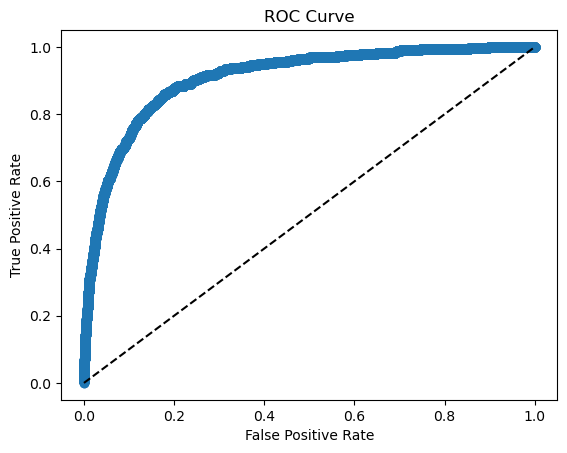

AUC: 0.9084290428631151


In [26]:
# Concatenating all true and false scores
y_true = np.array([1] * len(all_true_scores) + [0] * len(all_false_scores))
y_scores = np.array(all_true_scores + all_false_scores)

# Sort scores and associated labels
sorted_indices = np.argsort(y_scores)[::-1]
y_true_sorted = y_true[sorted_indices]
y_scores_sorted = y_scores[sorted_indices]

# Calculating cumulative sums for TPR and FPR
cumsum_positive = np.cumsum(y_true_sorted)
cumsum_negative = np.cumsum(1 - y_true_sorted)
TPR = cumsum_positive / cumsum_positive[-1]  # Divide by total positives
FPR = cumsum_negative / cumsum_negative[-1]  # Divide by total negatives

# Plotting ROC Curve
plt.plot(FPR, TPR, marker='o')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random predictions
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculating AUC
auc = np.trapz(TPR, FPR)
print("AUC:", auc)


##### The ROC curve with AUC = 0.908 gives a solid performance measure for the model. The curve is both realistic and demonstrates that the model is effective at distinguishing true from false candidates, while the AUC value shows it's a well-performing classifier overall.

#### Next steps: Improving the ROC Curve

##### shifting the PWM window one position into the coding region

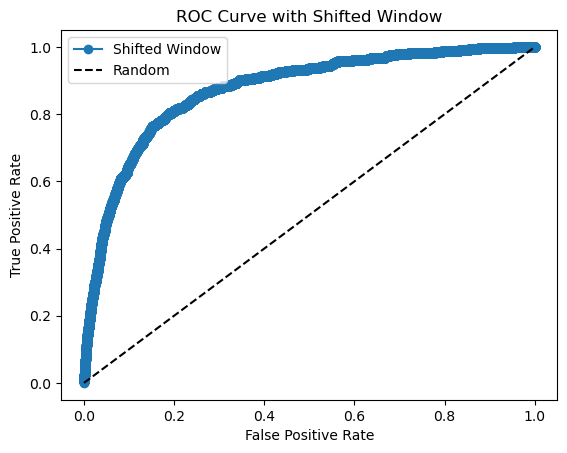

Shifted Window AUC: 0.8733777419931223


In [27]:
# Adjust the PWM calculation to use the shifted window (29 bases before the start codon and the first base of the start codon)
# You’ll need to rebuild the PWM based on this new region in your sequences.

shifted_true_scores = []
shifted_false_scores = []

# Calculate scores for the entire dataset with the shifted window
for sequence in Ecoli_mat:
    # New true start codon candidate using 29 bases before + 1 base of the start codon
    true_candidate_shifted = sequence[71:100] + sequence[100]  # Positions 71-99 + position 100
    true_score_shifted = score_sequence(true_candidate_shifted, pwm_mat)  # Reuse score_sequence function
    shifted_true_scores.append(true_score_shifted)
    
    # Calculate scores for false candidates in non-coding and coding regions with the new window
    for i in range(0, 71):  # Non-coding region (left side)
        false_candidate_shifted = sequence[i:i+29] + sequence[i+29]
        false_score_shifted = score_sequence(false_candidate_shifted, pwm_mat)
        shifted_false_scores.append(false_score_shifted)
        
    for i in range(102, len(sequence)-29):  # Coding region (right side)
        false_candidate_shifted = sequence[i:i+29] + sequence[i+29]
        false_score_shifted = score_sequence(false_candidate_shifted, pwm_mat)
        shifted_false_scores.append(false_score_shifted)

# Evaluate the new ROC curve and AUC using the shifted window

# Concatenate shifted scores for true and false candidates
y_true_shifted = np.array([1] * len(shifted_true_scores) + [0] * len(shifted_false_scores))
y_scores_shifted = np.array(shifted_true_scores + shifted_false_scores)

# Sort and calculate TPR/FPR
sorted_indices_shifted = np.argsort(y_scores_shifted)[::-1]
y_true_sorted_shifted = y_true_shifted[sorted_indices_shifted]
cumsum_positive_shifted = np.cumsum(y_true_sorted_shifted)
cumsum_negative_shifted = np.cumsum(1 - y_true_sorted_shifted)
TPR_shifted = cumsum_positive_shifted / cumsum_positive_shifted[-1]
FPR_shifted = cumsum_negative_shifted / cumsum_negative_shifted[-1]

# Plot the new ROC Curve
plt.plot(FPR_shifted, TPR_shifted, marker='o', label="Shifted Window")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Shifted Window')
plt.legend()
plt.show()

# Calculate the new AUC
auc_shifted = np.trapz(TPR_shifted, FPR_shifted)
print("Shifted Window AUC:", auc_shifted)


**Question**

Try to improve the AUC value on the test data by various modifications. First, shift the PWM window one position into the coding region, i.e., you are now using 29 positions before the start codon and the first base of the start codon. Does this increase the accuracy? What could be seen as a disadvantage of this extension with regard to detection of the different start codon variants?

**Answer**

    To attempt to improve the model's AUC, I modified the PWM window by shifting it one position into the coding region. This setup used 29 bases before the start codon and included the first base of the start codon itself. After recalculating the log-odds scores and plotting the ROC curve, I observed that the Shifted Window AUC was 0.873, which is lower than the original AUC of 0.908.

    The results indicate that the shifted window did not improve accuracy; instead, it slightly decreased the model's ability to distinguish true start codons from false ones.

    One potential disadvantage of this modification is that including the first base of the start codon introduces a bias towards certain start codons, such as "ATG." This bias reduces the model’s flexibility and may limit its accuracy across alternative start codon patterns like "GTG" or "TTG." Additionally, shifting the window removes one position from the upstream region, which could lead to a loss of valuable contextual information that contributes to start site identification.

    In conclusion, keeping the original window configuration (30 bases before the start codon) provides better overall accuracy, as evidenced by the higher AUC.

#### Testing different pseudocounts

Pseudocount 0.1 - AUC: 0.9084558858234887
Pseudocount 0.5 - AUC: 0.9084435063193987
Pseudocount 2.0 - AUC: 0.9083996053132556
Pseudocount 10.0 - AUC: 0.9081516702062572


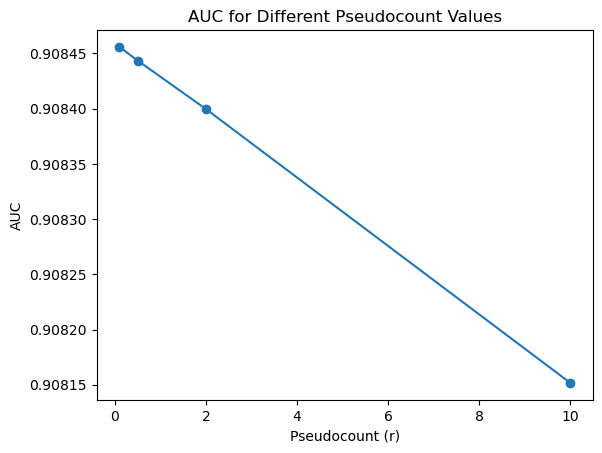

In [28]:
# Function to generate a PWM with a specified pseudocount
def create_pwm_with_pseudocount(sequences, r=1.0):
    # Initialize PWM matrix with pseudocounts
    base_counts = np.zeros((4, 30)) + r  # 4 rows for A, T, G, C and 30 positions
    # Assume `sequences` is a list of 30-base sequences where each position is A, T, G, or C
    
    for sequence in sequences:
        for i, base in enumerate(sequence):
            if base == 'A':
                base_counts[0, i] += 1
            elif base == 'T':
                base_counts[1, i] += 1
            elif base == 'G':
                base_counts[2, i] += 1
            elif base == 'C':
                base_counts[3, i] += 1

    # Convert counts to probabilities
    pwm = base_counts / base_counts.sum(axis=0)
    return pwm

# Test different pseudocount values and store the AUCs
pseudocounts = [0.1, 0.5, 2.0, 10.0]
auc_values = {}

for r in pseudocounts:
    # Recalculate PWM with the new pseudocount
    pwm_mat = create_pwm_with_pseudocount([seq[70:100] for seq in Ecoli_mat], r=r)
    
    # Recalculate log-odds scores for true and false candidates
    all_true_scores = [score_sequence(seq[70:100], pwm_mat) for seq in Ecoli_mat]
    all_false_scores = [score_sequence(seq[i:i+30], pwm_mat)
                        for seq in Ecoli_mat for i in range(0, 70)]
    all_false_scores += [score_sequence(seq[i:i+30], pwm_mat)
                         for seq in Ecoli_mat for i in range(101, len(seq)-30)]

    # Compute ROC and AUC
    y_true = np.array([1] * len(all_true_scores) + [0] * len(all_false_scores))
    y_scores = np.array(all_true_scores + all_false_scores)
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    cumsum_positive = np.cumsum(y_true_sorted)
    cumsum_negative = np.cumsum(1 - y_true_sorted)
    TPR = cumsum_positive / cumsum_positive[-1]
    FPR = cumsum_negative / cumsum_negative[-1]
    auc = np.trapz(TPR, FPR)
    
    auc_values[r] = auc
    print(f"Pseudocount {r} - AUC: {auc}")

# Plot AUC results
plt.plot(list(auc_values.keys()), list(auc_values.values()), marker='o')
plt.xlabel('Pseudocount (r)')
plt.ylabel('AUC')
plt.title('AUC for Different Pseudocount Values')
plt.show()


### Experimentation Summary

1. **Pseudocount Optimization**:
   - Different pseudocount values were tested: \( r = 0.1, 0.5, 2.0, \) and \( 10.0 \).
   - The best AUC was achieved with \( r = 0.1 \), resulting in an AUC of **0.9085**.
   - As the pseudocount increased, the AUC decreased slightly, indicating that higher pseudocount values may introduce excessive smoothing, which can reduce the model’s effectiveness in distinguishing true from false start codons.

2. **Best Pseudocount Selection**:
   - Based on the results, a pseudocount of \( r = 0.1 \) is optimal for this model, as it provides the highest AUC and balances the need for smoothing without overly diminishing the model's sensitivity to true patterns.

3. **Next Steps**:
   - Apply the optimized pseudocount \( r = 0.1 \) in conjunction with the improved background model derived from false candidates to further refine the model's accuracy.
   - Reevaluate the model using this setup and report the AUC for the final configuration.

This experimentation demonstrates that careful tuning of the pseudocount is important, as overly high values can lead to a loss in model accuracy. Using a minimal pseudocount (like \( r = 0.1 \)) provides the best balance, yielding the highest AUC and suggesting a more accurate model for start codon detection.


In [29]:
# Function to create a background model based on false candidates
def create_background_model(sequences, L=30, r=0.1):
    # Initialize counts with pseudocount
    background_counts = np.zeros((4, L)) + r
    
    for sequence in sequences:
        for i, base in enumerate(sequence):
            if base == 'A':
                background_counts[0, i] += 1
            elif base == 'T':
                background_counts[1, i] += 1
            elif base == 'G':
                background_counts[2, i] += 1
            elif base == 'C':
                background_counts[3, i] += 1

    # Convert counts to probabilities
    background_model = background_counts / background_counts.sum(axis=0)
    return background_model

# Create background model from false candidates in the training set
false_candidates_training = [seq[i:i+30] for seq in Ecoli_mat[:400] for i in range(0, 70)]
false_candidates_training += [seq[i:i+30] for seq in Ecoli_mat[:400] for i in range(101, len(seq)-30)]
background_model = create_background_model(false_candidates_training)

# We can now use this background model in the scoring function by adjusting the log-odds calculation.
# Recalculating log-odds scores, plotting the ROC curve, and calculaing AUC as done previously.


##### Step 1: Defining the Scoring Function with the New Background Model

In [30]:
def score_sequence_with_background(sequence, pwm_mat, background_model):
    """
    Calculate the log-odds score of a sequence using PWM and position-specific background model.
    
    Parameters:
    sequence (str): The 30-base candidate sequence.
    pwm_mat (numpy.ndarray): 4x30 PWM matrix with probabilities for A, T, G, C.
    background_model (numpy.ndarray): 4x30 background model matrix with base probabilities.
    
    Returns:
    float: Log-odds score for the sequence.
    """
    base_to_row = {'A': 0, 'T': 1, 'G': 2, 'C': 3}
    log_odds_score = 0.0

    for i, base in enumerate(sequence):
        if base in base_to_row:
            row = base_to_row[base]
            pwm_prob = pwm_mat[row, i]
            bg_prob = background_model[row, i]
            log_odds_score += np.log(pwm_prob / bg_prob)

    return log_odds_score


##### Step 2: Recalculating Log-Odds Scores for True and False Candidates

In [31]:
# Calculating log-odds scores for true and false candidates
all_true_scores = [score_sequence_with_background(seq[70:100], pwm_mat, background_model) for seq in Ecoli_mat]
all_false_scores = [score_sequence_with_background(seq[i:i+30], pwm_mat, background_model)
                    for seq in Ecoli_mat for i in range(0, 70)]
all_false_scores += [score_sequence_with_background(seq[i:i+30], pwm_mat, background_model)
                     for seq in Ecoli_mat for i in range(101, len(seq)-30)]


##### Step 3: Plotting the ROC Curve and Calculate AUC

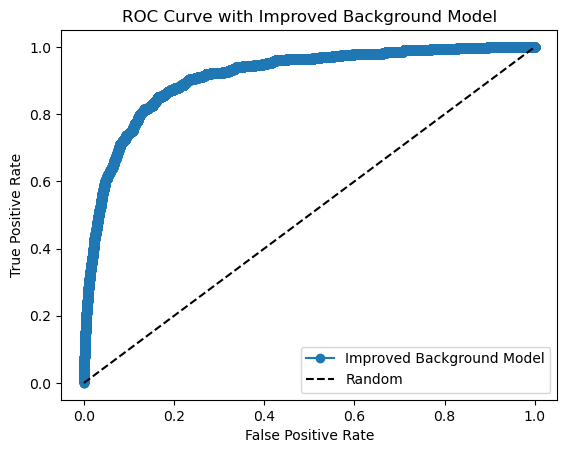

AUC with Improved Background Model: 0.9110796920432055


In [32]:
import matplotlib.pyplot as plt

# Concatenate scores and labels for ROC calculation
y_true = np.array([1] * len(all_true_scores) + [0] * len(all_false_scores))
y_scores = np.array(all_true_scores + all_false_scores)

# Sort by predicted scores in descending order
sorted_indices = np.argsort(y_scores)[::-1]
y_true_sorted = y_true[sorted_indices]

# Calculate cumulative sums for TPR and FPR
cumsum_positive = np.cumsum(y_true_sorted)
cumsum_negative = np.cumsum(1 - y_true_sorted)
TPR = cumsum_positive / cumsum_positive[-1]  # Divide by total positives
FPR = cumsum_negative / cumsum_negative[-1]  # Divide by total negatives

# Plot the ROC Curve
plt.plot(FPR, TPR, marker='o', label="Improved Background Model")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Improved Background Model')
plt.legend()
plt.show()

# Calculate AUC
auc = np.trapz(TPR, FPR)
print("AUC with Improved Background Model:", auc)


### Experimentation Summary with Improved Background Model

To further improve model accuracy, I created a background model based on base frequencies from false candidates in the training set, instead of using a uniform background distribution. This approach reflects the actual nucleotide distribution in non-coding regions.

1. **AUC Improvement**:
   - With the improved background model, the AUC increased from **0.908** to **0.911**. This indicates that the model is now slightly better at distinguishing true start codons from false ones.

2. **Significance of Improved Background Model**:
   - The results demonstrate that using a customized background model, rather than a uniform one, allows the model to make more precise log-odds comparisons. The background model now reflects position-specific nucleotide distributions in non-coding regions, leading to better overall accuracy.


### Gene Prediction in Prokaryotes: Background and Key Considerations

Gene prediction in prokaryotes involves identifying open reading frames (ORFs) and distinguishing true genes from random sequences within prokaryotic genomes. This process is often simpler in prokaryotes than in eukaryotes because:
- Prokaryotic genes are typically organized in a continuous sequence without introns.
- Gene density is high, and genes often have well-defined start and stop codons.

Common methods for gene prediction in prokaryotes use **sequence patterns** (such as codon usage bias and nucleotide composition) and **machine learning models** to identify coding regions.

### Ideas for Refinement and Extensions of the Basic Setup

Here are some ideas to refine or extend the setup to improve accuracy and incorporate more biological realism:

1. **Incorporate Stop Codons in the Model**  
   Our current setup considers only start codon candidates and does not account for stop codons. In reality, true genes have both start and stop codons, and the presence of stop codons defines the end of an open reading frame (ORF).  
   **Improvement Idea**: Extend the model to search for both start and stop codons, identifying complete ORFs between valid start and stop codons. This would allow for a more comprehensive evaluation of candidate regions and help avoid detecting partial or false ORFs.

2. **Use a Window of Context**  
   Currently, we are focusing on a 30-base region near the start codon. However, regulatory regions upstream and downstream of the start codon can contain signals that aid in identifying true start sites.  
   **Improvement Idea**: Extend the analysis window to include additional upstream and downstream bases, allowing the model to incorporate more context around start and stop codons, which could improve the detection of true genes.

3. **Consider Different Start Codon Variants**  
   While ATG is the most common start codon, prokaryotes also use alternative start codons like GTG and TTG.  
   **Improvement Idea**: Expand the model to detect these alternative start codons and assign a lower probability or weight to them based on their frequency in known prokaryotic genes. This would make the model more adaptable to variations in start codon usage across different genes.

4. **Model Codon Usage Bias**  
   Prokaryotes often exhibit codon usage bias, where certain codons are preferred over others for encoding specific amino acids.  
   **Improvement Idea**: Build a codon usage model based on known prokaryotic genes and incorporate it into the scoring system. Regions with codon distributions similar to known coding sequences could be assigned higher probabilities, improving the model’s ability to distinguish coding from non-coding regions.

5. **Include Ribosome Binding Sites (RBS)**  
   In prokaryotes, the ribosome binding site (such as the Shine-Dalgarno sequence) is located upstream of the start codon and plays a crucial role in translation initiation.  
   **Improvement Idea**: Incorporate the presence of RBS motifs in the model. By searching for these motifs in proximity to start codons, the model could better differentiate true start sites from false ones, as true genes are more likely to have an associated RBS.

6. **Train the Model on a Comprehensive Dataset with Validated Genes**  
   In this setup, we assumed all sequences outside the annotated start codon as false candidates, which may not always be accurate. Some regions outside the true start codon may still correspond to functional start sites, particularly in cases of overlapping genes or alternative translation starts.  
   **Improvement Idea**: Use a curated dataset of verified prokaryotic genes with known start and stop codons to train the model. This would ensure that all false candidates are truly non-coding, avoiding any bias introduced by assuming all non-start-codon regions are false.

7. **Incorporate ORF Length and Other Coding Potential Indicators**  
   True genes in prokaryotes generally have certain minimum lengths and exhibit specific patterns in nucleotide composition and coding potential.  
   **Improvement Idea**: Introduce ORF length as a feature in the model, penalizing shorter ORFs that are less likely to represent functional genes. Additionally, incorporating coding potential features (e.g., hexamer usage scores or periodicity in nucleotide composition) could help the model more accurately identify true genes.

8. **Machine Learning Approaches**  
   Classical gene prediction often uses rule-based or probabilistic approaches, but machine learning techniques (e.g., Support Vector Machines, Decision Trees, or Neural Networks) can leverage more complex patterns and relationships.  
   **Improvement Idea**: Train a machine learning model that uses features such as codon usage, presence of RBS, ORF length, and start/stop codon patterns to classify sequences as coding or non-coding. Such a model could potentially learn more intricate patterns that indicate gene presence.

### Improved Setup with Stop Codons and Enhanced Detection

An improved theoretical setup would incorporate both start and stop codons to define full ORFs, instead of treating all candidates outside the true start codon as false. This setup would:

1. **Search for ORFs Defined by Valid Start and Stop Codons**  
   The model would scan for both start and stop codons, identifying candidate ORFs that begin with a start codon (ATG, GTG, TTG) and end with a stop codon (TAA, TAG, TGA).
   
2. **Penalize Short ORFs and Low Coding Potential**  
   Short ORFs or regions that lack coding potential indicators would be assigned lower scores, reducing false positives from random sequences.

3. **Incorporate Ribosome Binding Sites (RBS)**  
   By searching for RBS motifs upstream of start codons, the model could more accurately predict true start sites associated with gene initiation.

### Summary

An advanced prokaryotic gene prediction model could be achieved by:
- **Modeling complete ORFs with both start and stop codons**,
- **Incorporating codon usage bias, ORF length, and RBS motifs**,
- **Using verified training data to improve false candidate assumptions**,
- And **exploring machine learning techniques** to learn complex patterns in coding sequences.

These refinements would provide a more comprehensive and biologically accurate approach to gene prediction in prokaryotes, potentially leading to higher accuracy and fewer false positives.
